_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [110]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits import mplot3d

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression

import graphviz
from sklearn.tree import export_graphviz

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [111]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

# Replace NAN in Numerical Variables
df['LotFrontage'] = df['LotFrontage'].interpolate()

# Replace NAN in Categorical Variables. 
df = df.fillna('Na')

# Find all columns where values are variables. 
ob_columns = df.select_dtypes(include='object').columns.tolist()
# Change those columns to categories, then use .cat.codes to encode them to int8
for col in ob_columns:     # 
    df[col+'Cat'] = df[col].astype('category').cat.codes
    
# Create a new Dataframe with only numbers to feed a model
num_df = df.select_dtypes(include = 'number')

num_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoningCat,StreetCat,AlleyCat,LotShapeCat,LandContourCat,UtilitiesCat,LotConfigCat,LandSlopeCat,NeighborhoodCat,Condition1Cat,Condition2Cat,BldgTypeCat,HouseStyleCat,RoofStyleCat,RoofMatlCat,Exterior1stCat,Exterior2ndCat,MasVnrTypeCat,MasVnrAreaCat,ExterQualCat,ExterCondCat,FoundationCat,BsmtQualCat,BsmtCondCat,BsmtExposureCat,BsmtFinType1Cat,BsmtFinType2Cat,HeatingCat,HeatingQCCat,CentralAirCat,ElectricalCat,KitchenQualCat,FunctionalCat,FireplaceQuCat,GarageTypeCat,GarageYrBltCat,GarageFinishCat,GarageQualCat,GarageCondCat,PavedDriveCat,PoolQCCat,FenceCat,MiscFeatureCat,SaleTypeCat,SaleConditionCat
0,1,60,65.0,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500,3,1,1,3,3,0,4,0,5,2,2,0,5,1,1,12,13,1,128,2,4,2,2,4,4,2,6,1,0,1,5,2,6,3,1,89,2,5,5,2,3,4,1,8,4
1,2,20,80.0,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500,3,1,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,0,3,4,1,2,4,1,0,6,1,0,1,5,3,6,5,1,62,2,5,5,2,3,4,1,8,4
2,3,60,68.0,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500,3,1,1,0,3,0,4,0,5,2,2,0,5,1,1,12,13,1,104,2,4,2,2,4,2,2,6,1,0,1,5,2,6,5,1,87,2,5,5,2,3,4,1,8,4
3,4,70,60.0,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000,3,1,1,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,0,3,4,0,4,1,4,0,6,1,2,1,5,2,6,2,5,84,3,5,5,2,3,4,1,8,0
4,5,60,84.0,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000,3,1,1,0,3,0,2,0,15,2,2,0,5,1,1,12,13,1,221,2,4,2,2,4,0,2,6,1,0,1,5,2,6,5,1,86,2,5,5,2,3,4,1,8,4


Lets try the kitchen sink. 

In [112]:
features = num_df.drop(columns = 'SalePrice').columns
target = ['SalePrice']

X = num_df.drop(columns = 'SalePrice')
y = num_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.8,
                                                    test_size= 0.2, 
                                                    random_state=42)

In [113]:
max_depth = 7

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)


Root Mean Squared Error 41345.62513574581
R^2 Score 0.7771332441814738


### Thats better kitchen sink performance than Linear Regression!!!

Let's try with the features I picked by the end of Tuesday. 

In [114]:
features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
            'YearRemodAdd','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF',
            '1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','FullBath',
            'BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
            'GarageArea','WoodDeckSF','OpenPorchSF','NeighborhoodCat',
            'MasVnrAreaCat','ExterCondCat','BsmtFinType2Cat','CentralAirCat',
            'FunctionalCat','GarageTypeCat']
target = ['SalePrice']


In [115]:
max_depth = 5

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)


Root Mean Squared Error 39385.186141339946
R^2 Score 0.7977670250928152


Not much of a performance improvement. Now I'm going to try the more selective data from yesterday

In [116]:
features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
            'YearRemodAdd','GrLivArea','BsmtFullBath','BedroomAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF',
            'NeighborhoodCat','MasVnrAreaCat','FunctionalCat','GarageTypeCat']

max_depth = 5

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)

Root Mean Squared Error 39385.186141339946
R^2 Score 0.7977670250928152


Let's try with a log result?

In [117]:
y_test = np.log(y_test)

In [118]:
features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
            'YearRemodAdd','GrLivArea','BsmtFullBath','BedroomAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF',
            'NeighborhoodCat','MasVnrAreaCat','FunctionalCat','GarageTypeCat']

max_depth = 5

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)

Root Mean Squared Error 197766.63480723105
R^2 Score -209586326917.83182


Well, that didn't work. Back to the normal test, but after removing outliers

In [119]:
num_df = num_df[np.abs(stats.zscore(num_df)< 3).all(axis=1)]

X = num_df.drop(columns = 'SalePrice')
y = num_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.8,
                                                    test_size= 0.2, 
                                                    random_state=42)

In [120]:
max_depth = 5

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)

Root Mean Squared Error 29706.03676789228
R^2 Score 0.7887250565554811


In [121]:
num_df['overall'] = np.multiply(num_df['OverallQual'], num_df['OverallCond'])
num_df['loc'] = np.multiply(num_df['NeighborhoodCat'], num_df['FunctionalCat'])

In [124]:
features = ['LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
            'YearRemodAdd','GrLivArea','BsmtFullBath','BedroomAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF',
            'NeighborhoodCat','MasVnrAreaCat','FunctionalCat','GarageTypeCat',
            'overall','loc']

X = num_df.drop(columns = 'SalePrice')
y = num_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.8,
                                                    test_size= 0.2, 
                                                    random_state=42)


Root Mean Squared Error 29580.06707108826
R^2 Score 0.7905130979137365


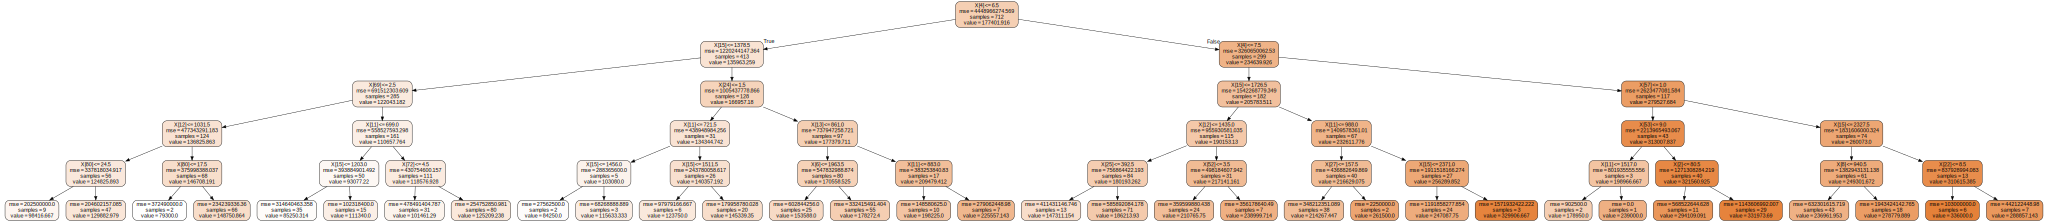

In [126]:
max_depth = 5

model = DecisionTreeRegressor(max_depth = max_depth )
model.fit(X_train , y_train)

y_pred = model.predict(X_test)
    

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print('Root Mean Squared Error', rmse)
print('R^2 Score', r2)

dot_data = export_graphviz(model, out_file=None, 
                           filled=True, rounded=True) 

graphviz.Source(dot_data)

Close enough. 

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [78]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [79]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [80]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [81]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [82]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [83]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html